## AI Agent Security in Production
### E2B Code Sandbox with Google Gemini
Execute AI-generated Python code in a secure sandbox environment.

## Setup and Imports

In [1]:
"""E2B Code Sandbox with Google Gemini."""
import warnings
warnings.filterwarnings('ignore')

import sys
import os
import base64
import pandas as pd
import time

root_dir = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(root_dir)

from dotenv import load_dotenv
load_dotenv()

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.tools import tool
from langchain.agents import create_agent
from langchain.messages import HumanMessage
from langgraph.checkpoint.memory import InMemorySaver

# Run AI Generated Code in Sandbox
from e2b_code_interpreter import Sandbox

In [2]:
os.path.dirname(os.path.dirname(os.getcwd()))

'd:\\Courses\\Udemy\\AI Agent Projects'

## Initialize Model and Sandbox

In [3]:
# gemini-2.5-flash
model = ChatGoogleGenerativeAI(model='gemini-3-flash-preview')

checkpointer = InMemorySaver()

In [23]:
sbx = Sandbox.create(timeout=40*60)
response = sbx.run_code('print(2+2)')
response = sbx.run_code('print(2/0)')

response

Execution(Results: [], Logs: Logs(stdout: [], stderr: []), Error: ExecutionError(name='ZeroDivisionError', value='division by zero', traceback='---------------------------------------------------------------------------ZeroDivisionError                         Traceback (most recent call last)Cell In[2], line 1\n----> 1 print(2/0)\nZeroDivisionError: division by zero'))

In [5]:
code = """import pandas as pd
import matplotlib.pyplot as plt

# Create sample sales dataset
data = {
    'product': ['Laptop', 'Mouse', 'Keyboard', 'Monitor', 'Headphones',
                'Laptop', 'Mouse', 'Keyboard', 'Monitor', 'Laptop'],
    'quantity': [5, 15, 10, 3, 8, 4, 20, 12, 2, 6],
    'price': [1200, 25, 75, 350, 150, 1200, 25, 75, 350, 1200]
}

df = pd.DataFrame(data)
df['revenue'] = df['quantity'] * df['price']

# Calculate total revenue by product
product_revenue = df.groupby('product')['revenue'].sum().sort_values(ascending=False)

# Print the data
print("Total Revenue by Product:")
print(product_revenue)

# Create bar chart
plt.figure(figsize=(10, 6))
product_revenue.plot(kind='bar', color='steelblue')
plt.title('Total Revenue by Product', fontsize=16, fontweight='bold')
plt.xlabel('Product', fontsize=12)
plt.ylabel('Revenue ($)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

# # Display the plot
# display(plt.gcf())"""
response = sbx.run_code(code)
response

Execution(Results: [Result(<Figure size 1000x600 with 1 Axes>)], Logs: Logs(stdout: ['Total Revenue by Product:\nproduct\nLaptop        18000\nMonitor        1750\nKeyboard       1650\nHeadphones     1200\nMouse           875\nName: revenue, dtype: int64\n'], stderr: []), Error: None)

In [6]:
# response.results[0].png

## Helper Tools

In [7]:
def get_dataset_info(file_path):
    if file_path.endswith=='.csv':
        df = pd.read_csv(file_path, nrows=3)

    else:
        df = pd.read_excel(file_path, nrows=3)

    return f"Columns: {list(df.columns)}\n Sample data:\n{df.to_string()}"

In [8]:
get_dataset_info(r'data\apple_2024.xlsx')

"Columns: ['APPLE INC. - FINANCIAL STATEMENTS 2024', 'Unnamed: 1']\n Sample data:\n  APPLE INC. - FINANCIAL STATEMENTS 2024   Unnamed: 1\n0                                    NaN          NaN\n1       BALANCE SHEET (as of 2024-09-30)          NaN\n2                                   Item  Value (USD)"

In [9]:
@tool
def upload_file(local_file_name: str):
    """Upload a data file to the E2B sandbox for analysis.
    
    Args:
        local_file_path: Local path to the file (e.g., "IMDB-Movie-Data.csv")
        
    Returns:
        Success message with sandbox_path and dataset_info
    """

    local_file_name = local_file_name.lstrip('/').lstrip('\\')
    local_file_path = f"./data/{local_file_name}"

    if not os.path.exists(local_file_path):
        return f"Error: file not found at {local_file_path}"
    
    with open(local_file_path, "rb") as f:
        sandbox_file = sbx.files.write(f"data/{local_file_name}", f)

    # dataset_info = get_dataset_info(local_file_path)

    return f"File uploaded successfully!\nSandbox path: {sandbox_file.path}"


In [10]:
upload_file.invoke("apple_2024.xlsx")

'File uploaded successfully!\nSandbox path: /home/user/data/apple_2024.xlsx'

In [11]:
@tool
def run_python_code(code: str):
    """Execute Python code in E2B sandbox.
    
    Args:
        code: Valid executable Python code. Do not pass anything else otherthan python code.
        
    Returns:
        Execution result
    """
    print('Running code in sandbox....')
    execution = sbx.run_code(code)
    print('Code execution is done!')

    if execution.error:
        return f"Error: {execution.error.name}\nValue: {execution.error.value}"
    
    os.makedirs('images', exist_ok=True)

    output = []
    timestamp = int(time.time())

    output.append(str(execution))

    for idx, result in enumerate(execution.results):
        if result.png:
            filename = f'images/{timestamp}_chart_{idx}.png'
            with open(filename, 'wb') as f:
                f.write(base64.b64decode(result.png))
            
            output.append(f"Chart saved to {filename}")

    return "\n".join(output) if output else "Code executed but no output was returned"

## Create Agent and Execute Query

In [12]:
from scripts import prompts
from langchain.agents.middleware import FilesystemFileSearchMiddleware

agent = create_agent(
    model=model,
    tools=[upload_file, run_python_code],
    system_prompt=prompts.CODE_EXECUTION_PROMPT,
    checkpointer=checkpointer,
    middleware=[
        FilesystemFileSearchMiddleware(
            root_path="./data",
            use_ripgrep=True,
            max_file_size_mb=1000)
    ]
)

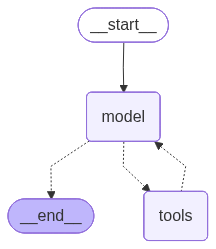

In [13]:
agent

### Code Execution Agent Testing

In [14]:
config = {"configurable": {"thread_id": "movie-1"}}

query = "Upload IMDB-Movie-Data.csv and create a line chart showing average ratings over years"

result = agent.invoke({'messages': [HumanMessage(query)]}, config=config)


Running code in sandbox....
Code execution is done!
Running code in sandbox....
Code execution is done!


In [18]:
# print(result['messages'][-1].text)

In [19]:
config = {"configurable": {"thread_id": "finance-1"}}

query = "Analyze apple 2024 data and calculate financial ratios"

result = agent.invoke({"messages": [HumanMessage(content=query)]}, config=config)


Running code in sandbox....
Code execution is done!
Running code in sandbox....
Code execution is done!
Running code in sandbox....
Code execution is done!
Running code in sandbox....
Code execution is done!
Running code in sandbox....
Code execution is done!
Running code in sandbox....
Code execution is done!


In [21]:
# print(result['messages'][-1].text)

In [24]:
query = "analyze google cashflow for 2024 and apple cashflow 2024. compare financial ratios. also show comparison table"

result = agent.invoke({"messages": [HumanMessage(content=query)]}, config=config)


Running code in sandbox....
Code execution is done!
Running code in sandbox....
Code execution is done!
Running code in sandbox....
Code execution is done!
Running code in sandbox....
Code execution is done!


In [26]:
# print(result['messages'][-1].text)

In [27]:
query = """Analyze the 2024 cash flow and financial performance of Google (Alphabet) and Apple.
Compute key financial ratios for both companies, including Gross Profit Margin,
Net Profit Margin, ROA, ROE, Current Ratio, and Debt-to-Equity Ratio.

Create the following visualizations:
1. A grouped bar chart comparing Apple vs Google for each financial ratio
   (x-axis: ratio names, y-axis: ratio values, separate bars for Apple and Google).
2. A comparison table summarizing all calculated ratios side by side.

Add clear titles, axis labels, legends, and use distinct colors for each company.
After generating the plots and table, interpret what the visual comparison reveals
about profitability, efficiency, liquidity, and leverage differences between Apple
and Google in 2024.
"""

config = {"configurable": {"thread_id": "finance-plots-1"}}

result = agent.invoke({"messages": [HumanMessage(content=query)]}, config=config)


Running code in sandbox....
Code execution is done!
Running code in sandbox....
Code execution is done!
Running code in sandbox....
Code execution is done!
Running code in sandbox....
Code execution is done!
Running code in sandbox....
Code execution is done!
Running code in sandbox....
Code execution is done!
Running code in sandbox....
Code execution is done!


In [30]:
# print(result['messages'][-1].text)

In [31]:
query = """
Using titanic.csv, calculate the survival rate for each passenger class (Pclass) and create a bar chart where 
the x-axis is Pclass (1, 2, 3) and the y-axis is survival rate (percentage of passengers who survived). 
Label the axes clearly and add a title explaining the insight.
"""

config = {"configurable": {"thread_id": "titanic-1"}}

result = agent.invoke({"messages": [HumanMessage(content=query)]}, config=config)
print(result['messages'][-1].text)

Running code in sandbox....
Code execution is done!
Running code in sandbox....
Code execution is done!
Based on the analysis of the `titanic.csv` dataset, the survival rates for each passenger class (Pclass) are as follows:

*   **Class 1 (First Class):** 63.0%
*   **Class 2 (Second Class):** 47.3%
*   **Class 3 (Third Class):** 24.2%

### Survival Rate by Passenger Class
The bar chart below illustrates the clear correlation between social class and the likelihood of survival, with first-class passengers having the highest survival rate and third-class passengers having the lowest.

![Survival Rate Bar Chart](images/1769778097_chart_0.png)


In [32]:
query = """
From titanic.csv, group passengers by Sex and Survived, 
then create a grouped bar chart where the x-axis is Sex (male, female), 
the y-axis is passenger count, and bars are split by survival status (0 = died, 1 = survived). 
Include a legend and interpret the result.
"""

result = agent.invoke({"messages": [HumanMessage(content=query)]}, config=config)
print(result['messages'][-1].text)

Running code in sandbox....
Code execution is done!
The survival distribution by gender on the Titanic reveals a significant disparity between male and female passengers:

### Passenger Count by Sex and Survival Status
The following chart shows the count of survivors versus non-survivors for each gender:

![Gender Survival Chart](images/1769778120_chart_0.png)

### Interpretation:
1.  **Female Survival Rate:** A vast majority of female passengers survived. Specifically, **233 women survived** while only **81 perished**, resulting in a survival rate of approximately **74.2%**.
2.  **Male Survival Rate:** The situation was reversed for men. Only **109 men survived**, while **468 perished**. This corresponds to a much lower survival rate of approximately **18.9%**.
3.  **"Women and Children First":** These results strongly reflect the maritime protocol of "women and children first" that was prioritized during the evacuation of the ship. Even though there were significantly more men on boa

In [33]:
query = """
Using the Fare column from titanic.csv, create a box plot comparing 
ticket fares of survivors and non-survivors, with Survived (0 = did not survive, 1 = survived)
 on the x-axis and Fare on the y-axis. Apply a logarithmic scale to the Fare axis 
 if the values are highly skewed. Use distinct colors for each survival group, 
 add clear axis labels, and set the plot title to “Ticket Fare Distribution by Survival 
 Status on the Titanic”. After generating the plot, briefly explain what it reveals about 
 the relationship between socioeconomic status and survival probability.
"""

result = agent.invoke({"messages": [HumanMessage(content=query)]}, config=config)
print(result['messages'][-1].text)

Running code in sandbox....
Code execution is done!
The box plot below compares the distribution of ticket fares between those who survived and those who did not, using a logarithmic scale to account for the wide range of prices.

### Ticket Fare Distribution by Survival Status on the Titanic
![Fare Box Plot](images/1769778128_chart_0.png)

### What the visualization reveals:

The plot highlights a clear relationship between **socioeconomic status** (represented by ticket fare) and **survival probability**:

1.  **Higher Median Fare for Survivors:** The median fare for survivors (**£26.0**) was more than double that of those who died (**£10.5**). This indicates that passengers who paid more for their tickets were significantly more likely to survive.
2.  **Concentration of Low Fares among Non-Survivors:** The box for those who died is much lower on the Y-axis, showing that the majority of non-survivors were passengers with cheaper, third-class tickets.
3.  **Outliers and High Fares:** 